### Notebook structure

- Intro and userful packages.
    - this section has to be compiled before all the others
- **Excercise 11.1** : trying to improve a linear fit with different model of Neural Network.
- **Excercise 11.2** : doing same for a third degree polinomial fit.
- **Excercise 11.4** : extending the model to fit a trigonometric bi-dimesional function.


In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
from statistics import mode
# compose the NN model
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects


sns.set_theme(style='whitegrid', palette='bright')  # Set Seaborn theme and color palette
cm = plt.get_cmap('tab20')  # Get a color map for use in plots


2023-11-02 17:44:09.658613: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 17:44:12.470101: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Exercise 11.1

In this excercise I explore how does the linear regression depend on the number of epochs, $N_{\mathrm{epochs}}$, the number of data points $N_{\mathrm{train}}$ and on the noise $\sigma$ and I try to improve the previous result operating on these parameters.

In [2]:
# target parameters of f(x) = m*x + b
m = 2  # slope
b = 1  # intersect


First let's have a look at the training and validation data for different values of $\sigma$.

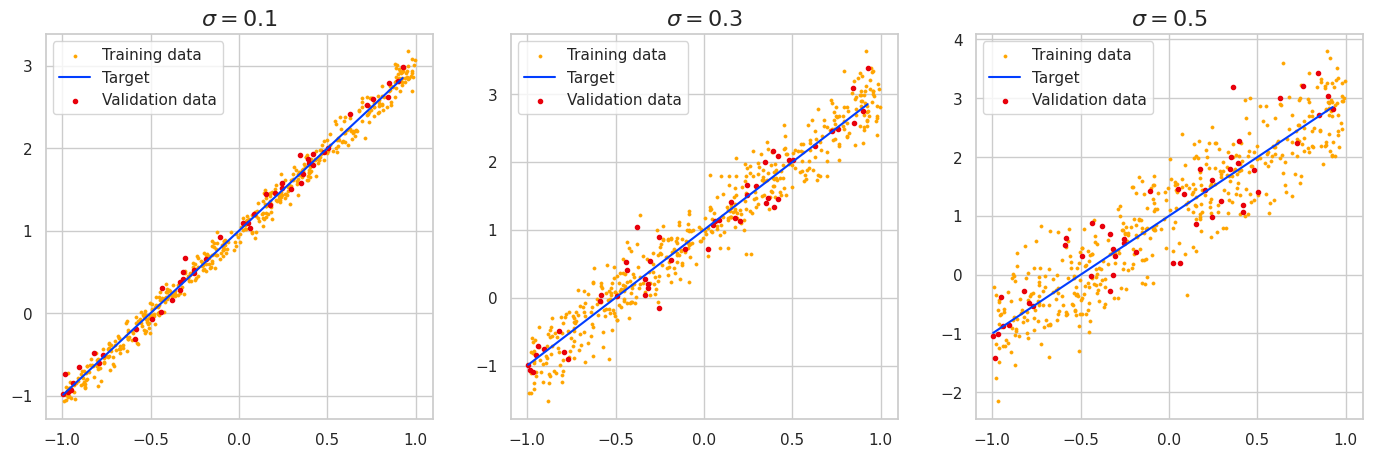

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Define the true linear function
m = 2  # Slope
b = 1  # Intercept

N_train = 500 # Size of the training sample

# Generate training inputs
np.random.seed(0)
x_train = np.random.uniform(-1, 1, N_train)
x_valid = np.random.uniform(-1, 1, 50) # size of the test sample
x_valid.sort()
y_target = m * x_valid + b  # Ideal (target) linear function

sigmas = [0.1, 0.3, 0.5]  # Noise standard deviation

plt.figure(figsize=(17, 5))

for i in range(3):
    # Generate noisy data
    y_train = np.random.normal(m * x_train + b, sigmas[i], size=x_train.shape)
    y_valid = np.random.normal(m * x_valid + b, sigmas[i], size=x_valid.shape)

    plt.subplot(1, 3, i + 1)
    plt.scatter(x_train, y_train, s=5, color='orange',
                label='Training data', linewidth=0.5)
    plt.plot(x_valid, y_target, label='Target')
    plt.scatter(x_valid, y_valid, color='r',
                label='Validation data', marker=".")
    plt.title("$\sigma=$" + str(sigmas[i]), fontsize=16)
    plt.legend()
    plt.grid(True)

plt.show()


First I need to decide the dimension of the test sample with respect to the train sample.

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:36<00:00,  7.23s/it]


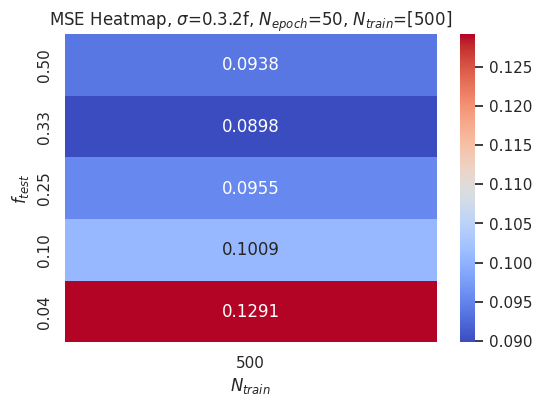

In [4]:
# Define parameters
N_epochs = 50
m = 2  # Slope
b = 1  # Intercept

# Create arrays to store the MSE values
sigma = 0.3
N_train_values = [500]
N_epochs = 50
N_test_frac = [1/2, 1/3, 1/4, 1/10, 1/25]
mse_values = np.zeros((len(N_test_frac), len(N_train_values)))


# Create a tqdm instance to display the progress bar
pbar = tqdm(total=len(N_test_frac) * len(N_train_values))

for i, test_frac in enumerate(N_test_frac):  # Fix variable name
    for j, N_train in enumerate(N_train_values):
        x_valid = np.random.uniform(-1, 1, int(N_train * test_frac))
        x_train = np.random.uniform(-1, 1, int(N_train))
        y_train = np.random.normal(
            m * x_train + b, sigma, size=x_train.shape)  # Use sigma_values
        y_valid = np.random.normal(
            m * x_valid + b, sigma, size=x_valid.shape)  # Use sigma_values

        model = tf.keras.Sequential()
        model.add(Dense(1, input_shape=(1,)))
        model.compile(optimizer='sgd', loss='mse', metrics=['mse'])
        history = model.fit(x=x_train, y=y_train, batch_size=32, epochs=int(
            N_epochs), shuffle=True, validation_data=(x_valid, y_valid), verbose=0)

        mse_values[i, j] = history.history['val_mse'][-1]
        pbar.update(1)  # Update the progress bar

pbar.close()  # Close the progress bar

# Create a heatmap of the MSE values
fig, ax = plt.subplots(figsize=(6, 4))
yticklabels = [f"{val:.2f}" for val in N_test_frac] 
sns.heatmap(mse_values, annot=True, ax=ax, cmap="coolwarm",
            xticklabels=N_train_values, yticklabels=yticklabels, fmt=".4f")
ax.set_title(
    f"MSE Heatmap, $\sigma$={sigma}.2f, $N_{{epoch}}$={N_epochs}, $N_{{train}}$={N_train_values}")
ax.set_ylabel("$f_{test}$")
ax.set_xlabel("$N_{train}$")
plt.show()


Observing the plot I chose to set $N_\text{test}=N_\text{train}/4$. Now I'll explore how the MSE vary for different combination of $\sigma$, $N_{epoch}$ (number of epoch for training) and $N_{train}$ (size of the training sample). In the following calculation I consider the size of the test sample to be $1/4$ of that of the training sample.

  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [02:23<00:00,  8.95s/it]


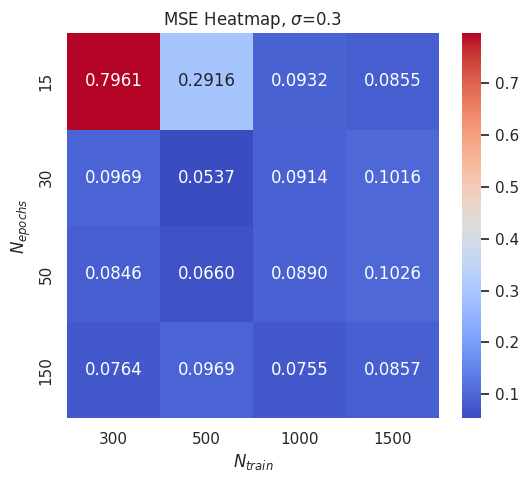

In [45]:
# Define parameters
m = 2  # Slope
b = 1  # Intercept

# Create arrays to store the MSE values
sigma = 0.3
N_train_values = [300, 500, 1000, 1500]
N_epochs_values = [15, 30, 50, 150]
mse_values = np.zeros((len(N_epochs_values), len(N_train_values)))


# Create a tqdm instance to display the progress bar
pbar = tqdm(total=len(N_epochs_values) * len(N_train_values))

for i, N_epochs in enumerate(N_epochs_values):  # Fix variable name
    for j, N_train in enumerate(N_train_values):
        x_valid = np.random.uniform(-1, 1, N_train//4)
        x_train = np.random.uniform(-1, 1, int(N_train))
        y_train = np.random.normal(
            m * x_train + b, sigma, size=x_train.shape)  # Use sigma_values
        y_valid = np.random.normal(
            m * x_valid + b, sigma, size=x_valid.shape)  # Use sigma_values

        model = tf.keras.Sequential()
        model.add(Dense(1, input_shape=(1,)))
        model.compile(optimizer='sgd', loss='mse', metrics=['mse'])
        history = model.fit(x=x_train, y=y_train, batch_size=32, epochs=int(
            N_epochs), shuffle=True, validation_data=(x_valid, y_valid), verbose=0)

        mse_values[i, j] = history.history['val_mse'][-1]
        pbar.update(1)  # Update the progress bar

pbar.close()  # Close the progress bar

# Create a heatmap of the MSE values
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(mse_values, annot=True, ax=ax, cmap="coolwarm",
            xticklabels=N_train_values, yticklabels=N_epochs_values, fmt=".4f")
ax.set_title(f"MSE Heatmap, $\sigma$={sigma}")
ax.set_ylabel("$N_{epochs}$")
ax.set_xlabel("$N_{train}$")
plt.show()


100%|██████████| 16/16 [02:01<00:00,  7.58s/it]


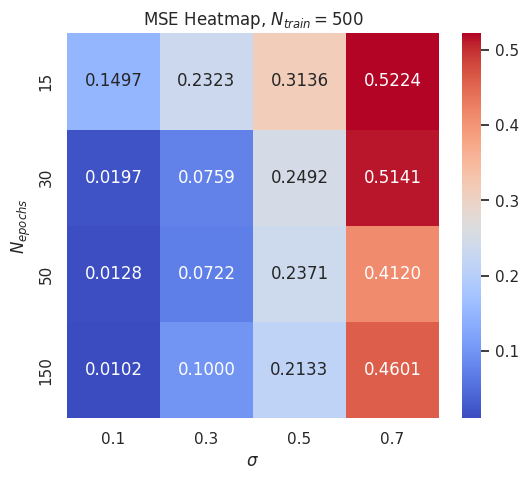

In [46]:
# Define parameters
m = 2  # Slope
b = 1  # Intercept

# Create arrays to store the MSE values
N_train = 500
sigma_values = [0.1, 0.3, 0.5, 0.7]
N_epochs_values = [15, 30, 50, 150]
mse_values = np.zeros((len(N_epochs_values), len(sigma_values)))

# Create a tqdm instance to display the progress bar
pbar = tqdm(total=len(N_epochs_values) * len(sigma_values))

for i, N_epochs in enumerate(N_epochs_values):
    for j, sigma in enumerate(sigma_values):
        # Use a fixed size for the validation set
        x_valid = np.random.uniform(-1, 1, N_train//4)
        x_train = np.random.uniform(-1, 1, N_train)
        y_train = np.random.normal(m * x_train + b, sigma, size=x_train.shape)
        y_valid = np.random.normal(m * x_valid + b, sigma, size=x_valid.shape)

        model = tf.keras.Sequential()
        model.add(Dense(1, input_shape=(1,)))
        model.compile(optimizer='sgd', loss='mse', metrics=['mse'])
        history = model.fit(x=x_train, y=y_train, batch_size=32, epochs=N_epochs,
                            shuffle=True, validation_data=(x_valid, y_valid), verbose=0)
        mse_values[i, j] = history.history['val_mse'][-1]
        pbar.update(1)  # Update the progress bar

pbar.close()  # Close the progress bar

# Create a heatmap of the MSE values
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(mse_values, annot=True, ax=ax, cmap="coolwarm",
            xticklabels=sigma_values, yticklabels=N_epochs_values, fmt=".4f")
ax.set_title(f"MSE Heatmap, $N_{{train}}={N_train}$")
ax.set_ylabel("$N_{epochs}$")
ax.set_xlabel("$\sigma$")
plt.show()


As the value of $\sigma$ (representing uncertainties in target output values) increases, neural networks tend to produce less accurate results.
Training models on complex datasets with significant errors requires anticipating longer training times and considering increasing the amount of available data.

Increasing the size of the training dataset results in reduced errors in neural network predictions. 
Maintaining a balanced ratio between the training and test datasets is crucial.

Significant differences in accuracy achieved with varying training dataset sizes become less critical with an increase in the number of training epochs. Increasing the number of training epochs extends the training time, allowing the model to search more extensively for the minimum in parameter space. However, this prolonged training also increases the risk of overfitting, where the model starts to mimic statistical fluctuations in the training dataset, making it ineffective in analyzing new data.In linear systems like the one analyzed, the likelihood of overfitting is lower.

A balance between data in the training and test sets, along with a sufficient number of training epochs, is essential for intelligent neural network training. For a better fit I chose to set $N_\text{Train}$ = 500 and $N_\text{epoch}=50$, taking into consideration the balance between the performance of the model and the execution time.

4/4 [==============================] - 0s 4ms/step
Predicted weights:  [array([[1.9797643]], dtype=float32), array([1.0071918], dtype=float32)]
Expected weights:  2 ,  1


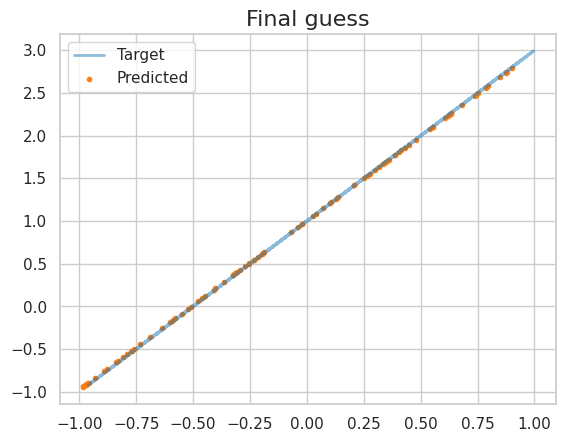

In [47]:
cm = plt.get_cmap('tab20')
# Define parameters
m = 2  # Slope
b = 1  # Intercept

# Create arrays to store the MSE values
sigma = 0.3
N_train = 500
N_epochs = 50
mse_values = np.zeros((len(N_epochs_values), len(N_train_values)))

x_valid = np.random.uniform(-1, 1, N_train//4)
y_target = m * x_valid + b  # Ideal (target) linear function
x_train = np.random.uniform(-1, 1, int(N_train))
y_train = np.random.normal(m * x_train + b, sigma,
                           size=x_train.shape)  # Use sigma_values
y_valid = np.random.normal(
    m * x_valid + b, sigma, size=x_valid.shape)  # Use sigma_values

model = tf.keras.Sequential()
model.add(Dense(1, input_shape=(1,)))
model.compile(optimizer='sgd', loss='mse', metrics=['mse'])
history = model.fit(x=x_train, y=y_train, batch_size=32, epochs=int(
    N_epochs), shuffle=True, validation_data=(x_valid, y_valid), verbose=0)

x_predicted = np.random.uniform(-1, 1, 100)
y_predicted = model.predict(x_predicted)
plt.plot(x_valid, y_target, label='Target',color=cm(0),linewidth=2,alpha=0.5)
plt.scatter(x_predicted, y_predicted, marker='.', color=cm(2), label='Predicted')
plt.title('Final guess', fontsize=16)
plt.legend()
plt.grid(True)

print ("Predicted weights: ",model.get_weights())
print ("Expected weights: ", m,", ",b)
plt.show()




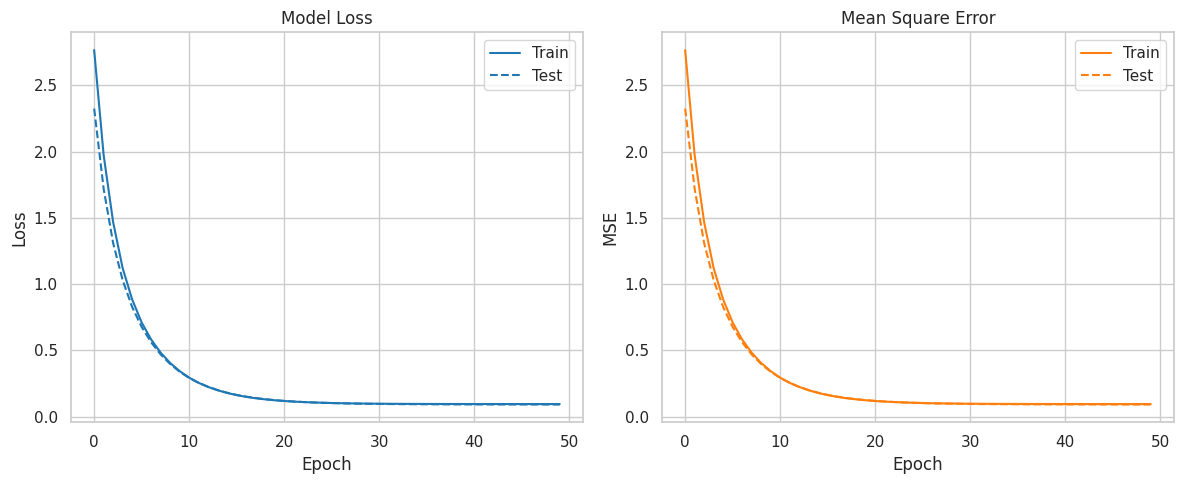

In [48]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)

plt.plot(history.history['loss'],color=cm(0))
plt.plot(history.history['val_loss'],linestyle='--',color=cm(0))
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')

# Plot training & validation accuracy values (using MSE as a measure of accuracy)
plt.subplot(1, 2, 2)
plt.plot(history.history['mse'],color=cm(2))  # 'mse' for training accuracy
plt.plot(history.history['val_mse'],linestyle='--',color=cm(2))  # 'val_mse' for validation accuracy
plt.title('Mean Square Error')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')

plt.tight_layout()
plt.show()



The training loss (Train) generally decreases over epochs, which is expected as the model becomes better at fitting the training data.
The validation loss (Test) shows how well the model generalizes to unseen data. The goal is to have the training and validation loss decrease together, indicating that the model is learning and generalizing effectively.
If the training loss continues to decrease while the validation loss increases, it could suggest overfitting, where the model memorizes the training data but struggles with new data.

# Excercise 11.2
In this second part of the exercise, we aim to address a slightly more complex problem, which involves fitting the function:
$$
f(x)=4-3x-2x^2+3x^3
$$
for $x \in [-1,1]$.

While doing so, I want to analyze how the choices regarding the architecture and optimization of the neural network (NN) can influence the results. In this analysis, I will explore different optimizers, the number of hidden layers, the number of nodes per hidden layer, and activation functions. Fisrt I will visualize the function:

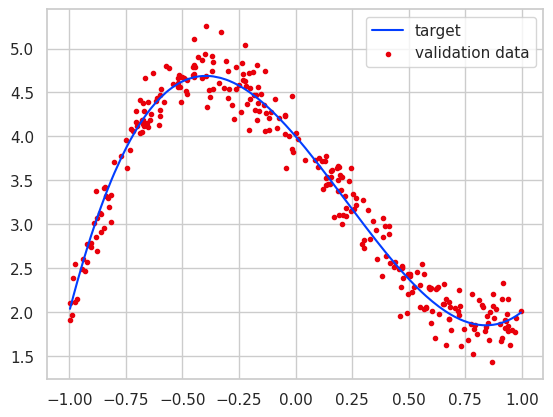

In [15]:
def f(x):
    return a + b*x + c*x**2 + d*x**3


# parameters of f(x) = a+bx+cx^2+dx^3
a = 4
b = -3
c = -2
d = 3

N_train = 3000

np.random.seed(0)
x_train = np.random.uniform(-1, 1, N_train)
x_valid = np.random.uniform(-1, 1, N_train//4)
x_valid.sort()
y_target = f(x_valid)  # ideal (target) polynomial

y_train = np.zeros((3, len(x_train)))  # Define y_train as a matrix
y_valid = np.zeros((3, len(x_valid)))  # Define y_valid as a matrix
y_train = np.random.normal(f(x_train), sigma)
y_valid = np.random.normal(f(x_valid), sigma)

# plot validation and target dataset
plt.plot(x_valid, y_target, label='target')
plt.scatter(x_valid, y_valid, color='r', label='validation data', marker='.')
plt.legend()
plt.grid(True)
plt.show()


Here are some possible choiche of parameters:

In [57]:
# Some possible choice
opts = ['rmsProp', 'Adam', 'SGD']
acts = ['relu', 'selu',  'tanh']
N_layers = [1, 2, 4]
N_nodes = [4, 8, 32]


In [58]:
def DNN_model(num_hidden_layers, optimizer, num_nodes, activation_func):
    # Create a sequential model
    model = tf.keras.Sequential()
    # Input layer with linear activation
    model.add(Dense(units=16, input_shape=(1,), activation='linear'))
    # Hidden layers based on the number of hidden layers specified
    for _ in range(num_hidden_layers):
        model.add(Dense(units=num_nodes, activation=activation_func))
    # Output layer with linear activation
    model.add(Dense(units=1, activation='linear'))
    # Compile the model with the specified optimizer and loss function
    model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])

    return model


For all three optimizer I will randomly choose the free parameters from the lists

In [59]:
# Import the random module
import random

# Generate training inputs
N_train = 3000
N_epochs = 30
sigma = 0.2

np.random.seed(0)
x_train = np.random.uniform(-1, 1, N_train)
x_valid = np.random.uniform(-1, 1, N_train // 4)
x_valid.sort()
y_target = f(x_valid)

# Generate noisy training and validation data
y_train = np.random.normal(f(x_train), sigma, size=x_train.shape)
y_valid = np.random.normal(f(x_valid), sigma, size=x_valid.shape)

models = []  # Store the models
hists = []
labels = []  # Store labels for the models

# Initialize tqdm with the total number of iterations
total_iterations = len(opts)
pbar = tqdm(total=total_iterations)

# Iterate through different configurations
for i,opt in enumerate(opts):
    nod = N_nodes[i]
    act = acts[i]
    lay = N_layers[i]
    label = f'DNN({opt}, {lay}, {nod}, {act})'
    labels.append(label)
    model = DNN_model(lay, opt, nod, act)
    models.append(model)
    hist = model.fit(x=x_train, y=y_train, batch_size=20,
                     epochs=N_epochs, validation_data=(x_valid, y_valid), verbose=0)
    hists.append(hist)
    pbar.update(1)  # Update the progress bar

pbar.close()  # Close the progress bar


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [01:20<00:00, 26.91s/it]


In [60]:
# evaluate model

for i in range(len(models)):
    score = models[i].evaluate(x_valid, y_valid, batch_size=32, verbose=1)
    # print performance
    print(labels[i])
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])


10/10 [==============================] - 0s 3ms/step - loss: 0.0619 - mse: 0.0619
DNN(rmsProp, 1, 4, relu)
Test loss: 0.0619298554956913
Test accuracy: 0.0619298554956913
10/10 [==============================] - 1s 6ms/step - loss: 0.0430 - mse: 0.0430
DNN(Adam, 2, 8, selu)
Test loss: 0.042960651218891144
Test accuracy: 0.042960651218891144
10/10 [==============================] - 0s 3ms/step - loss: 0.0410 - mse: 0.0410
DNN(SGD, 4, 32, tanh)
Test loss: 0.04103008285164833
Test accuracy: 0.04103008285164833


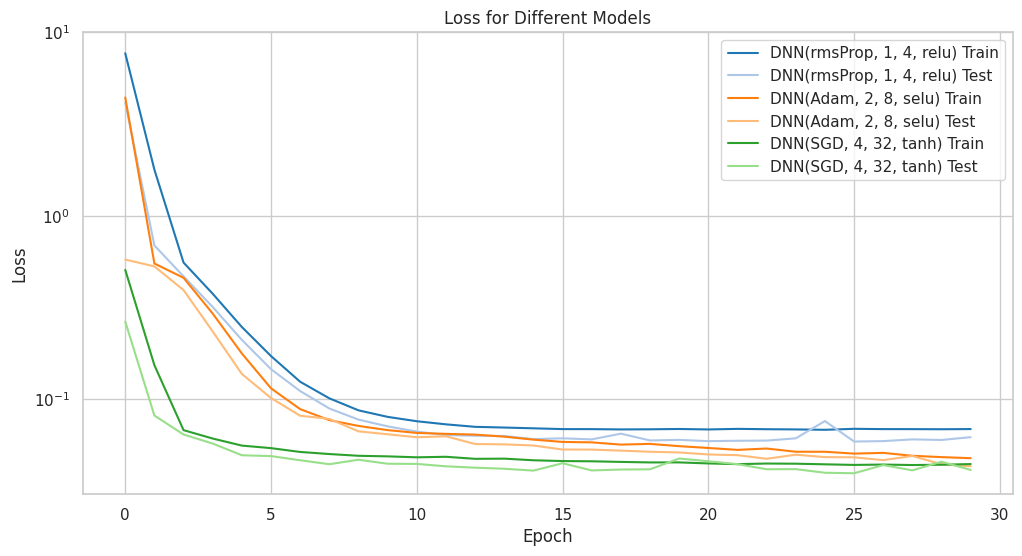

In [61]:
cm = plt.get_cmap('tab20')

plt.figure(figsize=(12, 6))

for i in range(len(hists)):
    plt.plot(hists[i].history['loss'], color=cm(2 * i), label=labels[i] + ' Train')
    plt.plot(hists[i].history['val_loss'], color=cm(2 * i + 1), label=labels[i] + ' Test')

plt.title('Loss for Different Models')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.yscale('log')
plt.grid(True)
plt.show()

Legend : 
 - DNN(optimizer, number of hidden layers, number of nodes , activation function)
 
I selected a linear activation function for the input and output layers, while I used other activation functions in the hidden layers. This is why I included random selection at the beginning of the program, allowing for choices between relu, selu, and tanh. 
From the previous plot it can be observed that augmenting the number of hidden layers and nodes for each layer have a positive impact on the loss function.

 1/16 [>.............................] - ETA: 0s

16/16 [==============================] - 0s 4ms/step


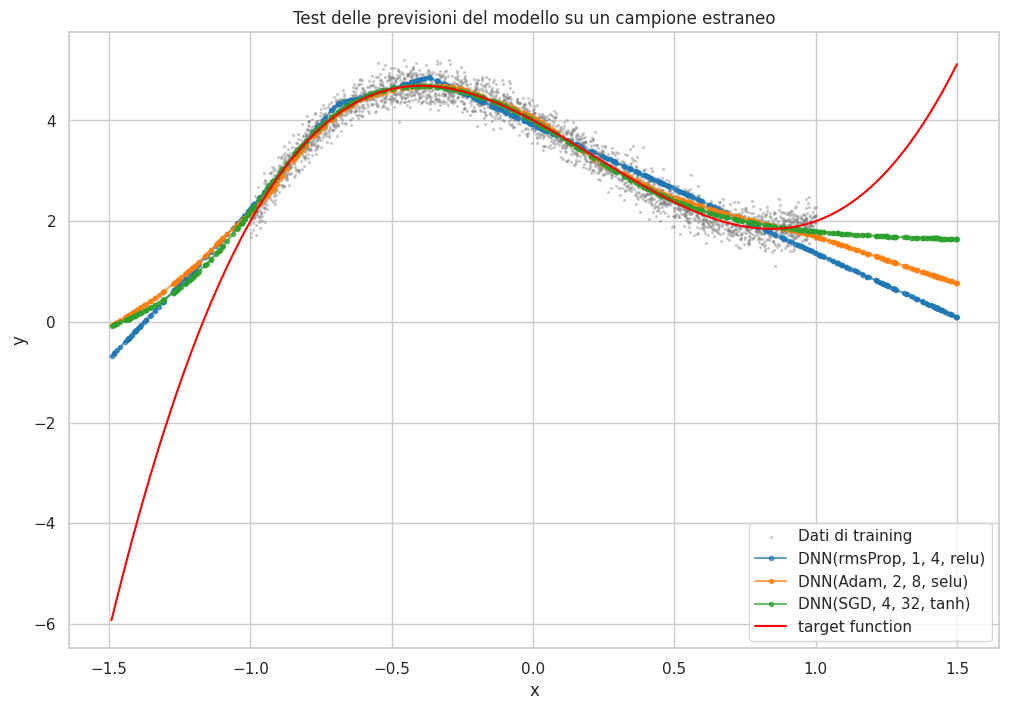

In [69]:
x_out = np.random.uniform(-1.5,1.5,500)
x_out.sort()
y_out = f(x_out)

plt.figure(figsize=(12,8))
plt.title('Test delle previsioni del modello su un campione estraneo')

plt.scatter(x_train, y_train, alpha= 0.3, label='Dati di training', marker='.', s=8, color='grey')

for i in range(3):
    plt.plot(x_out, models[i].predict(x_out), color=cm(2*i), alpha=0.7, label=labels[i],marker = '.')
plt.plot(x_out,y_out, color='red',label='target function')
plt.ylabel('y')
plt.xlabel('x')
plt.legend()
plt.show()

The blu curve, realized with just one hidden layer with 4 nodes is the more different from the target function, while the orange and green curve are quite similar in the original interval even though the architecture is different. This could be due to the fact that the 'Adam' optimizer usually have better results. 

It is evident that an important aspect of approaching a machine learning-based fitting problem is selecting the appropriate tools. While one would be inclined towards creating intricate models, for maximal adaptability to various systems. However it's crucial to take into consideration the computational costs of training.


### Exercise 11.3
  
In this last excercise I extend the model to fit a simple trigonometric 2D function such as $$f(x,y) = \sin(x^2+y^2)$$ in the range $x \in [-3/2,3/2]$ and $y \in [-3/2,3/2]$.

In [87]:

model = tf.keras.Sequential()
model.add(Dense(units=16, input_shape=(2,), activation='linear'))   #attivazione iniziale lineare
model.add(Dense(units=32, activation='selu'))                       #interna selu
model.add(Dense(units=32, activation='elu'))                        #ed elu
model.add(Dense(units=1, activation='linear'))                      #attivazione finale lineare
model.compile(optimizer='adam', loss='mse', metrics=['mse'])
model.summary()


Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_153 (Dense)           (None, 16)                48        
                                                                 
 dense_154 (Dense)           (None, 32)                544       
                                                                 
 dense_155 (Dense)           (None, 32)                1056      
                                                                 
 dense_156 (Dense)           (None, 1)                 33        
                                                                 
Total params: 1681 (6.57 KB)
Trainable params: 1681 (6.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


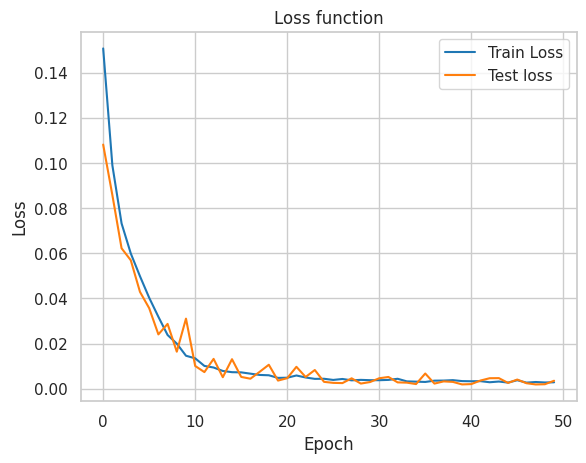

In [88]:
def f(x,y):
    return np.sin(x**2+y**2)

N_train = 10000
N_epochs = 50
sigma = 0.02

x_train = np.random.uniform(-1.5, 1.5, N_train)
y_train = np.random.uniform(-1.5, 1.5, N_train)

x_valid = np.random.uniform(-1.5, 1.5, N_train//4)
y_valid = np.random.uniform(-1.5, 1.5, N_train//4)

z_target = np.sin(x_valid**2 + y_valid**2)

z_train = np.random.normal(np.sin(x_train**2 + y_train**2), sigma) 
z_valid = np.random.normal(np.sin(x_valid**2 + y_valid**2), sigma)
# anche in questa cella ho cancellato i log di keras

xy_train = np.column_stack((x_train, y_train))
xy_valid = np.column_stack((x_valid, y_valid))

hist = model.fit(x=xy_train, y=z_train, 
              batch_size=32, epochs=N_epochs, 
              validation_data=(xy_valid, z_valid), shuffle=True, verbose=0)

plt.title('Loss function')
plt.plot(hist.history['loss'], color=cm(0), label='Train Loss')
plt.plot(hist.history['val_loss'],  color=cm(i), label='Test loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

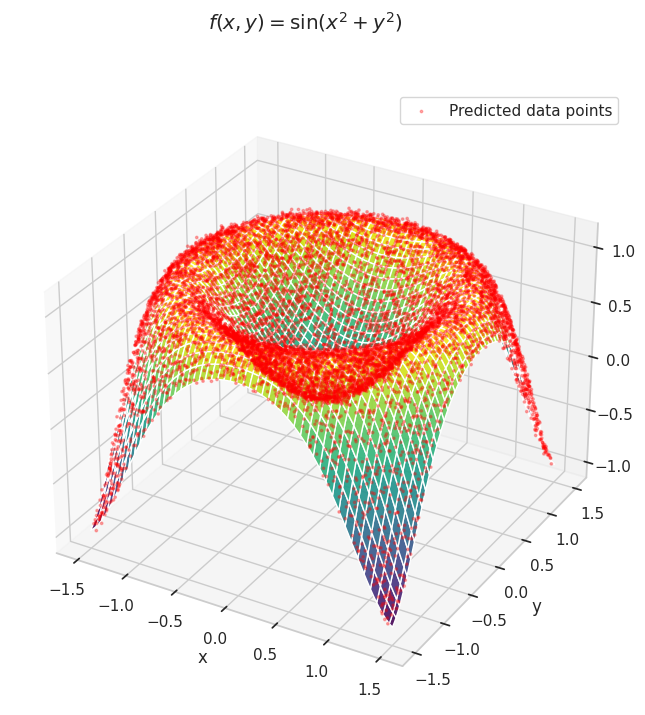

In [118]:
from mpl_toolkits.mplot3d import Axes3D

# Create a mesh grid of (x, y) values
x = np.linspace(-1.5, 1.5, 100)
y = np.linspace(-1.5, 1.5, 100)
x, y = np.meshgrid(x, y)

# Calculate the corresponding z values using the analytical function
z_analytic = f(x, y)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
plt.suptitle(r'$ f(x,y)=\sin (x^2+y^2)$')

# Plot the analytical function as a wireframe
ax.plot_surface(x, y, z_analytic, cmap='viridis', alpha=0.9, label='Analytic function')

# Scatter your training data points
scatter = ax.scatter(x_train, y_train, z_train, c='red', marker='o', s=3, alpha=0.3, depthshade=True)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

# Manually create a legend
ax.legend([scatter], ['Predicted data points'], loc='best')

plt.show()
